# CenterResnet Starter


I am very new to these concepts so I am trying out by changing this amazing and probably only 3D model related awesome public kernel by Ruslan
https://www.kaggle.com/hocop1/centernet-baseline

Most of the codes are loaned from there . There are other codes that I took from OFT implementation github . But I dont know what is OFT , so I have not yet implemented it . 

My current score is not from this kernel( as there are some errors in this kernel) , but from some simple architecture modification of the original public kernel. 


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import os
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
from tqdm.auto import tqdm as tq
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import transforms, utils

PATH = '../input/pku-autonomous-driving/'
os.listdir(PATH)

['car_models_json',
 'test_masks.zip',
 'test_images',
 'test_images.zip',
 'sample_submission.csv',
 'car_models',
 'train.csv',
 'camera.zip',
 'test_masks',
 'train_masks',
 'car_models_json.zip',
 'train_masks.zip',
 'train_images',
 'camera',
 'train_images.zip',
 'car_models.zip']

In [2]:
## Constants
SWITCH_LOSS_EPOCH = 5

# Load data

In [3]:
train = pd.read_csv(PATH + 'train.csv')
test = pd.read_csv(PATH + 'sample_submission.csv')

# From camera.zip
camera_matrix = np.array([[2304.5479, 0,  1686.2379],
                          [0, 2305.8757, 1354.9849],
                          [0, 0, 1]], dtype=np.float32)
camera_matrix_inv = np.linalg.inv(camera_matrix)

train.head()

,ImageId,PredictionString
0,ID_8a6e65317,16 0.254839 -2.57534 -3.10256 7.96539 3.20066 ...
1,ID_337ddc495,66 0.163988 0.192169 -3.12112 -3.17424 6.55331...
2,ID_a381bf4d0,43 0.162877 0.00519276 -3.02676 2.1876 3.53427...
3,ID_7c4a3e0aa,43 0.126957 -3.04442 -3.10883 -14.738 24.6389 ...
4,ID_8b510fad6,37 0.16017 0.00862796 -3.0887 -3.04548 3.4977 ...


**ImageId** column contains names of images:

In [24]:
def imread(path, fast_mode=False):
    img = cv2.imread(path)
    if not fast_mode and img is not None and len(img.shape) == 3:
        img = np.array(img[:, :, ::-1])
    return img

img = imread(PATH + 'train_images/ID_8a6e65317' + '.jpg')
IMG_SHAPE = img.shape

# plt.figure(figsize=(15,8))
# plt.imshow(img);

In [5]:
def str2coords(s, names=['id', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']):
    '''
    Input:
        s: PredictionString (e.g. from train dataframe)
        names: array of what to extract from the string
    Output:
        list of dicts with keys from `names`
    '''
    coords = []
    for l in np.array(s.split()).reshape([-1, 7]):
        coords.append(dict(zip(names, l.astype('float'))))
        if 'id' in coords[-1]:
            coords[-1]['id'] = int(coords[-1]['id'])
    return coords

In [6]:
inp = train['PredictionString'][0]
print('Example input:\n', inp)
print()
print('Output:\n', str2coords(inp))

Example input:
 16 0.254839 -2.57534 -3.10256 7.96539 3.20066 11.0225 56 0.181647 -1.46947 -3.12159 9.60332 4.66632 19.339 70 0.163072 -1.56865 -3.11754 10.39 11.2219 59.7825 70 0.141942 -3.1395 3.11969 -9.59236 5.13662 24.7337 46 0.163068 -2.08578 -3.11754 9.83335 13.2689 72.9323

Output:
 [{'id': 16, 'yaw': 0.254839, 'pitch': -2.57534, 'roll': -3.10256, 'x': 7.96539, 'y': 3.20066, 'z': 11.0225}, {'id': 56, 'yaw': 0.181647, 'pitch': -1.46947, 'roll': -3.12159, 'x': 9.60332, 'y': 4.66632, 'z': 19.339}, {'id': 70, 'yaw': 0.163072, 'pitch': -1.56865, 'roll': -3.11754, 'x': 10.39, 'y': 11.2219, 'z': 59.7825}, {'id': 70, 'yaw': 0.141942, 'pitch': -3.1395, 'roll': 3.11969, 'x': -9.59236, 'y': 5.13662, 'z': 24.7337}, {'id': 46, 'yaw': 0.163068, 'pitch': -2.08578, 'roll': -3.11754, 'x': 9.83335, 'y': 13.2689, 'z': 72.9323}]


# Data distributions

I guess, pitch and yaw are mixed up in this dataset. Pitch cannot be that big. That would mean that cars are upside down.

In [7]:
def rotate(x, angle):
    x = x + angle
    x = x - (x + np.pi) // (2 * np.pi) * 2 * np.pi
    return x


# 2D Visualization

In [8]:
def get_img_coords(s):
    '''
    Input is a PredictionString (e.g. from train dataframe)
    Output is two arrays:
        xs: x coordinates in the image
        ys: y coordinates in the image
    '''
    coords = str2coords(s)
    xs = [c['x'] for c in coords]
    ys = [c['y'] for c in coords]
    zs = [c['z'] for c in coords]
    P = np.array(list(zip(xs, ys, zs))).T
    img_p = np.dot(camera_matrix, P).T
    img_p[:, 0] /= img_p[:, 2]
    img_p[:, 1] /= img_p[:, 2]
    img_xs = img_p[:, 0]
    img_ys = img_p[:, 1]
    img_zs = img_p[:, 2] # z = Distance from the camera
    return img_xs, img_ys

In [9]:
from math import sin, cos

# convert euler angle to rotation matrix
def euler_to_Rot(yaw, pitch, roll):
    Y = np.array([[cos(yaw), 0, sin(yaw)],
                  [0, 1, 0],
                  [-sin(yaw), 0, cos(yaw)]])
    P = np.array([[1, 0, 0],
                  [0, cos(pitch), -sin(pitch)],
                  [0, sin(pitch), cos(pitch)]])
    R = np.array([[cos(roll), -sin(roll), 0],
                  [sin(roll), cos(roll), 0],
                  [0, 0, 1]])
    return np.dot(Y, np.dot(P, R))

def draw_line(image, points):
    color = (255, 0, 0)
    cv2.line(image, tuple(points[0][:2]), tuple(points[3][:2]), color, 16)
    cv2.line(image, tuple(points[0][:2]), tuple(points[1][:2]), color, 16)
    cv2.line(image, tuple(points[1][:2]), tuple(points[2][:2]), color, 16)
    cv2.line(image, tuple(points[2][:2]), tuple(points[3][:2]), color, 16)
    return image


def draw_points(image, points):
    for (p_x, p_y, p_z) in points:
        cv2.circle(image, (p_x, p_y), int(1000 / p_z), (0, 255, 0), -1)
#         if p_x > image.shape[1] or p_y > image.shape[0]:
#             print('Point', p_x, p_y, 'is out of image with shape', image.shape)
    return image

def visualize(img, coords):
    # You will also need functions from the previous cells
    x_l = 1.02
    y_l = 0.80
    z_l = 2.31
    
    img = img.copy()
    for point in coords:
        # Get values
        x, y, z = point['x'], point['y'], point['z']
        yaw, pitch, roll = -point['pitch'], -point['yaw'], -point['roll']
        # Math
        Rt = np.eye(4)
        t = np.array([x, y, z])
        Rt[:3, 3] = t
        Rt[:3, :3] = euler_to_Rot(yaw, pitch, roll).T
        Rt = Rt[:3, :]
        P = np.array([[x_l, -y_l, -z_l, 1],
                      [x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, -z_l, 1],
                      [0, 0, 0, 1]]).T
        img_cor_points = np.dot(camera_matrix, np.dot(Rt, P))
        img_cor_points = img_cor_points.T
        img_cor_points[:, 0] /= img_cor_points[:, 2]
        img_cor_points[:, 1] /= img_cor_points[:, 2]
        img_cor_points = img_cor_points.astype(int)
        # Drawing
        img = draw_line(img, img_cor_points)
        img = draw_points(img, img_cor_points[-1:])
    
    return img

# Image preprocessing

In [10]:
IMG_WIDTH = 2048
IMG_HEIGHT = IMG_WIDTH // 4
MODEL_SCALE = 8

def _regr_preprocess(regr_dict):
    for name in ['x', 'y', 'z']:
        regr_dict[name] = regr_dict[name] / 100
    regr_dict['roll'] = rotate(regr_dict['roll'], np.pi)
    regr_dict['pitch_sin'] = sin(regr_dict['pitch'])
    regr_dict['pitch_cos'] = cos(regr_dict['pitch'])
    regr_dict.pop('pitch')
    regr_dict.pop('id')
    return regr_dict

def _regr_back(regr_dict):
    for name in ['x', 'y', 'z']:
        regr_dict[name] = regr_dict[name] * 100
    regr_dict['roll'] = rotate(regr_dict['roll'], -np.pi)
    
    pitch_sin = regr_dict['pitch_sin'] / np.sqrt(regr_dict['pitch_sin']**2 + regr_dict['pitch_cos']**2)
    pitch_cos = regr_dict['pitch_cos'] / np.sqrt(regr_dict['pitch_sin']**2 + regr_dict['pitch_cos']**2)
    regr_dict['pitch'] = np.arccos(pitch_cos) * np.sign(pitch_sin)
    return regr_dict

def preprocess_image(img):
    img = img[img.shape[0] // 2:]
    bg = np.ones_like(img) * img.mean(1, keepdims=True).astype(img.dtype)
    bg = bg[:, :img.shape[1] // 4]
    img = np.concatenate([bg, img, bg], 1)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    return (img / 255).astype('float32')

def get_mask_and_regr(img, labels):
    mask = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE], dtype='float32')
    regr_names = ['x', 'y', 'z', 'yaw', 'pitch', 'roll']
    regr = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE, 7], dtype='float32')
    coords = str2coords(labels)
    xs, ys = get_img_coords(labels)
    for x, y, regr_dict in zip(xs, ys, coords):
        x, y = y, x
        x = (x - img.shape[0] // 2) * IMG_HEIGHT / (img.shape[0] // 2) / MODEL_SCALE
        x = np.round(x).astype('int')
        y = (y + img.shape[1] // 4) * IMG_WIDTH / (img.shape[1] * 1.5) / MODEL_SCALE
        y = np.round(y).astype('int')
        if x >= 0 and x < IMG_HEIGHT // MODEL_SCALE and y >= 0 and y < IMG_WIDTH // MODEL_SCALE:
            mask[x, y] = 1
            regr_dict = _regr_preprocess(regr_dict)
            regr[x, y] = [regr_dict[n] for n in sorted(regr_dict)]
    return mask, regr

# PyTorch Dataset

In [11]:
class CarDataset(Dataset):
    """Car dataset."""

    def __init__(self, dataframe, root_dir, training=True, transform=None):
        self.df = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.training = training

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Get image name
        idx, labels = self.df.values[idx]
        img_name = self.root_dir.format(idx)
        
        # Read image
        img0 = imread(img_name, True)
        img = preprocess_image(img0)
        img = np.rollaxis(img, 2, 0)
        
        # Get mask and regression maps
        if self.training:
            mask, regr = get_mask_and_regr(img0, labels)
            regr = np.rollaxis(regr, 2, 0)
        else:
            mask, regr = 0, 0
        
        return [img, mask, regr]
    
train_images_dir = PATH + 'train_images/{}.jpg'
test_images_dir = PATH + 'test_images/{}.jpg'

df_train, df_dev = train_test_split(train, test_size=0.01, random_state=42)
df_test = test

# Create dataset objects
train_dataset = CarDataset(df_train, train_images_dir)
dev_dataset = CarDataset(df_dev, train_images_dir)
test_dataset = CarDataset(df_test, test_images_dir)

BATCH_SIZE = 2

# Create data generators - they will produce batches
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
dev_loader = DataLoader(dataset=dev_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# PyTorch Model

In [12]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
        else:
            x = x1
        x = self.conv(x)
        return x

def get_mesh(batch_size, shape_x, shape_y):
    mg_x, mg_y = np.meshgrid(np.linspace(0, 1, shape_y), np.linspace(0, 1, shape_x))
    mg_x = np.tile(mg_x[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mg_y = np.tile(mg_y[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mesh = torch.cat([torch.tensor(mg_x).to(device), torch.tensor(mg_y).to(device)], 1)
    return mesh

import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.GroupNorm(16, planes)

        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.GroupNorm(16, planes)

        if stride != 1 or inplanes != planes:
            self.downsample = nn.Sequential(
                conv1x1(inplanes, planes, stride), nn.GroupNorm(16, planes))
        else:
            self.downsample = None


    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out, inplace=True)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.GroupNorm(16, planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.GroupNorm(16, planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.GroupNorm(16, planes * self.expansion)

        if stride != 1 or inplanes != planes * self.expansion:
            self.downsample = nn.Sequential(
                conv1x1(inplanes, planes * self.expansion, stride), 
                nn.GroupNorm(16, planes * self.expansion))
        else:
            self.downsample = None

    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = F.relu(self.bn2(self.conv2(out)), inplace=True)
        out = self.bn3(self.conv3(out))
 
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out)

        return out


class ResNetFeatures(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
        super(ResNetFeatures, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.GroupNorm(16, 64)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):

        layers = []
        layers.append(block(self.inplanes, planes, stride))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x):
        conv1 = F.relu(self.bn1(self.conv1(x)), inplace=True)
        conv1 = F.max_pool2d(conv1, 3, stride=2, padding=1)

        feats4 = self.layer1(conv1)
        feats8 = self.layer2(feats4)
        feats16 = self.layer3(feats8)
        feats32 = self.layer4(feats16)

        return feats8, feats16, feats32


def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNetFeatures(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        _load_pretrained(model, model_zoo.load_url(model_urls['resnet18']))
    return model



def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNetFeatures(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        _load_pretrained(model, model_zoo.load_url(model_urls['resnet34']))
    return model


def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNetFeatures(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        _load_pretrained(model, model_zoo.load_url(model_urls['resnet34']))
    return model


def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNetFeatures(BasicBlock, [3, 4, 23, 3], **kwargs)
    if pretrained:
        _load_pretrained(model, model_zoo.load_url(model_urls['resnet34']))
    return model

def _load_pretrained(model, pretrained):
    model_dict = model.state_dict()
    pretrained = {k : v for k, v in pretrained.items() if k in model_dict}
    model_dict.update(pretrained)
    model.load_state_dict(model_dict)

In [13]:
class CentResnet(nn.Module):
    '''Mixture of previous classes'''
    def __init__(self, n_classes):
        super(CentResnet, self).__init__()
        self.base_model = resnet18(pretrained=False)
        
        # Lateral layers convert resnet outputs to a common feature size
        self.lat8 = nn.Conv2d(128, 256, 1)
        self.lat16 = nn.Conv2d(256, 256, 1)
        self.lat32 = nn.Conv2d(512, 256, 1)
        self.bn8 = nn.GroupNorm(16, 256)
        self.bn16 = nn.GroupNorm(16, 256)
        self.bn32 = nn.GroupNorm(16, 256)

       
        self.conv0 = double_conv(5, 64)
        self.conv1 = double_conv(64, 128)
        self.conv2 = double_conv(128, 512)
        self.conv3 = double_conv(512, 1024)
        
        self.mp = nn.MaxPool2d(2)
        
        self.up1 = up(1282 , 512) #+ 1024
        self.up2 = up(512 + 512, 256)
        self.outc = nn.Conv2d(256, n_classes, 1)
        
    
    def forward(self, x):
        batch_size = x.shape[0]
        mesh1 = get_mesh(batch_size, x.shape[2], x.shape[3])
        x0 = torch.cat([x, mesh1], 1)
        x1 = self.mp(self.conv0(x0))
        x2 = self.mp(self.conv1(x1))
        x3 = self.mp(self.conv2(x2))
        x4 = self.mp(self.conv3(x3))
        
        #feats = self.base_model.extract_features(x)
                # Run frontend network
        feats8, feats16, feats32 = self.base_model(x)
        lat8 = F.relu(self.bn8(self.lat8(feats8)))
        lat16 = F.relu(self.bn16(self.lat16(feats16)))
        lat32 = F.relu(self.bn32(self.lat32(feats32)))
        
        # Add positional info
        mesh2 = get_mesh(batch_size, lat32.shape[2], lat32.shape[3])
        feats = torch.cat([lat32, mesh2], 1)
        #print(feats.shape)
        #print (x4.shape)
        x = self.up1(feats, x4)
        x = self.up2(x, x3)
        x = self.outc(x)
        return x

In [14]:
# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

n_epochs = 12 #6

model = CentResnet(8).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
#optimizer =  RAdam(model.parameters(), lr = 0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=max(n_epochs, 10) * len(train_loader) // 3, gamma=0.1)

img_batch = torch.randn((1,3,512,2048))

test = model(img_batch.to(device))

cuda


/home/dohee/anaconda3/envs/CenterNet/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


# Training

In [15]:
def criterion(prediction, mask, regr,weight=0.4, size_average=True):
    # Binary mask loss
    pred_mask = torch.sigmoid(prediction[:, 0])
#     mask_loss = mask * (1 - pred_mask)**2 * torch.log(pred_mask + 1e-12) + (1 - mask) * pred_mask**2 * torch.log(1 - pred_mask + 1e-12)
    mask_loss = mask * torch.log(pred_mask + 1e-12) + (1 - mask) * torch.log(1 - pred_mask + 1e-12)
    mask_loss = -mask_loss.mean(0).sum()
    
    # Regression L1 loss
    pred_regr = prediction[:, 1:]
    regr_loss = (torch.abs(pred_regr - regr).sum(1) * mask).sum(1).sum(1) / mask.sum(1).sum(1)
    regr_loss = regr_loss.mean(0)
  
    # Sum
    loss = weight*mask_loss +(1-weight)* regr_loss
    if not size_average:
        loss *= prediction.shape[0]
    return loss ,mask_loss , regr_loss

In [16]:
def train(epoch, history=None):
    model.train()
    t = tqdm(train_loader)
    for batch_idx, (img_batch, mask_batch, regr_batch) in enumerate(t):
        img_batch = img_batch.to(device)
        mask_batch = mask_batch.to(device)
        regr_batch = regr_batch.to(device)
        
        optimizer.zero_grad()
        output = model(img_batch)
        if epoch < SWITCH_LOSS_EPOCH :
            loss,mask_loss, regr_loss = criterion(output, mask_batch, regr_batch,1)
        else:
            loss,mask_loss, regr_loss = criterion(output, mask_batch, regr_batch,0.5)  
        
        t.set_description(f'train_loss (l={loss:.3f})(m={mask_loss:.2f}) (r={regr_loss:.4f}')
        
        if history is not None:
            history.loc[epoch + batch_idx / len(train_loader), 'train_loss'] = loss.data.cpu().numpy()
        
        loss.backward()
        
        optimizer.step()
        exp_lr_scheduler.step()

    
    print('Train Epoch: {} \tLR: {:.6f}\tLoss: {:.6f}\tMaskLoss: {:.6f}\tRegLoss: {:.6f}'.format(
        epoch,
        optimizer.state_dict()['param_groups'][0]['lr'],
        loss.data,
        mask_loss.data,
        regr_loss.data))

def evaluate(epoch, history=None):
    model.eval()
    loss = 0
    valid_loss = 0
    valid_mask_loss = 0
    valid_regr_loss = 0
    with torch.no_grad():
        for img_batch, mask_batch, regr_batch in dev_loader:
            img_batch = img_batch.to(device)
            mask_batch = mask_batch.to(device)
            regr_batch = regr_batch.to(device)

            output = model(img_batch)

            if epoch < SWITCH_LOSS_EPOCH :
                loss,mask_loss, regr_loss= criterion(output, mask_batch, regr_batch,1, size_average=False)
                valid_loss += loss.data
                valid_mask_loss += mask_loss.data
                valid_regr_loss += regr_loss.data
            else :
                loss,mask_loss, regr_loss = criterion(output, mask_batch, regr_batch,0.5, size_average=False)
                valid_loss += loss.data
                valid_mask_loss += mask_loss.data
                valid_regr_loss += regr_loss.data 

    
    valid_loss /= len(dev_loader.dataset)
    valid_mask_loss /= len(dev_loader.dataset)
    valid_regr_loss /= len(dev_loader.dataset)
    
    if history is not None:
        history.loc[epoch, 'dev_loss'] = valid_loss.cpu().numpy()
        history.loc[epoch, 'mask_loss'] = valid_mask_loss.cpu().numpy()
        history.loc[epoch, 'regr_loss'] = valid_regr_loss.cpu().numpy()

    
    print('Dev loss: {:.4f}'.format(valid_loss))

In [17]:

%%time
import gc

history = pd.DataFrame()

for epoch in range(n_epochs):
    torch.cuda.empty_cache()
    gc.collect()
    train(epoch, history)
    evaluate(epoch, history)
    
    
torch.save(model.state_dict(), './model_resnet50.pth')

/home/dohee/anaconda3/envs/CenterNet/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


RuntimeError: CUDA error: out of memory

In [ ]:
history['train_loss'].iloc[100:].plot();

series1 = history.dropna()['mask_loss']
plt.plot(series1.index, series1 ,label = 'mask loss');
series2 = history.dropna()['regr_loss']
plt.plot(series2.index, 30*series2,label = 'regr loss');
series3 = history.dropna()['dev_loss']
plt.plot(series3.index, series3,label = 'dev loss');
plt.show()

series = history.dropna()['dev_loss']
plt.scatter(series.index, series);

In [17]:
model.load_state_dict(torch.load('./model.pth'))
model.eval();

# Visualize predictions

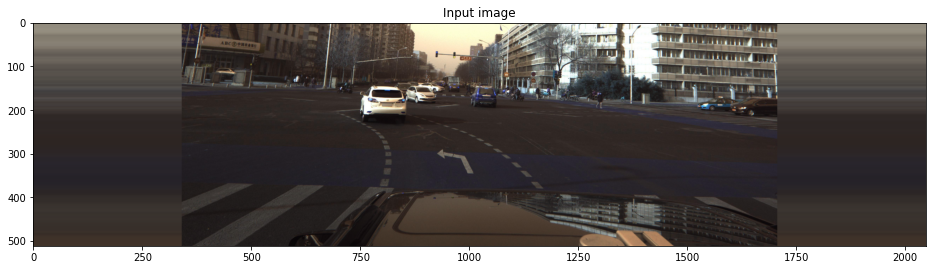

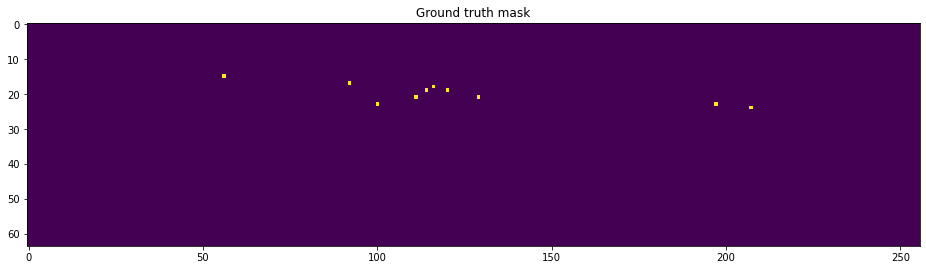

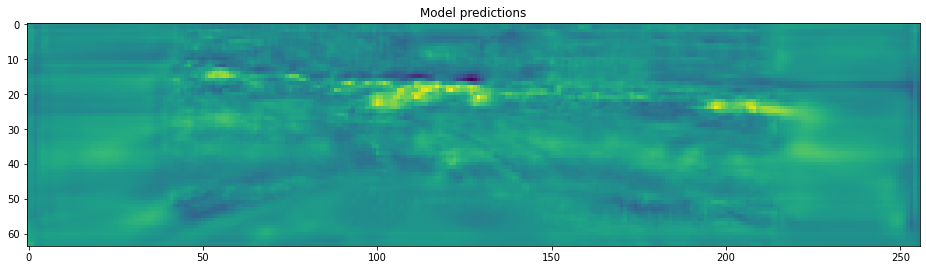

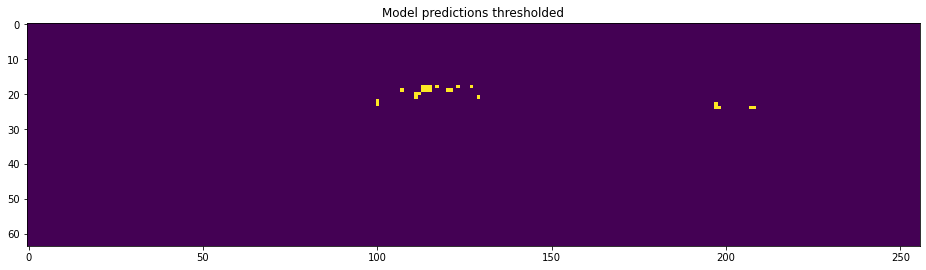

In [18]:
img, mask, regr = dev_dataset[0]

plt.figure(figsize=(16,16))
plt.title('Input image')
plt.imshow(np.rollaxis(img, 0, 3))
plt.show()

plt.figure(figsize=(16,16))
plt.title('Ground truth mask')
plt.imshow(mask)
plt.show()

output = model(torch.tensor(img[None]).to(device))
logits = output[0,0].data.cpu().numpy()

plt.figure(figsize=(16,16))
plt.title('Model predictions')
plt.imshow(logits)
plt.show()

plt.figure(figsize=(16,16))
plt.title('Model predictions thresholded')
plt.imshow(logits > -2)
plt.show()

In [ ]:
# Validation

In [19]:
## Simple test of probabilities
act = torch.nn.Sigmoid()
logtens = torch.from_numpy(logits)
probs = act(logtens)
probs = probs[probs>0.03]
print(probs)

tensor([0.0335, 0.0418, 0.0375, 0.0479, 0.0382, 0.1455, 0.1282, 0.1706, 0.0553,
        0.6526, 0.0741, 0.0432, 0.1792, 0.0724, 0.2887, 0.0373, 0.0805, 0.1351,
        0.4358, 0.6599, 0.1841, 0.2258, 0.7842, 0.0407, 0.0609, 0.0404, 0.0488,
        0.1643, 0.2570, 0.0663, 0.0346, 0.0635, 0.6135, 0.1061, 0.8344, 0.0569,
        0.3201, 0.0577, 0.0676, 0.5332, 0.0745, 0.1400, 0.0689, 0.1157, 0.1036,
        0.0555, 0.6543, 0.1771, 0.0383, 0.4293, 0.5270, 0.0445, 0.0367, 0.0394,
        0.0412, 0.0481, 0.0302])


In [20]:
DISTANCE_THRESH_CLEAR = 2

def convert_3d_to_2d(x, y, z, fx = 2304.5479, fy = 2305.8757, cx = 1686.2379, cy = 1354.9849):
    # stolen from https://www.kaggle.com/theshockwaverider/eda-visualization-baseline
    return x * fx / z + cx, y * fy / z + cy

def optimize_xy(r, c, x0, y0, z0):
    def distance_fn(xyz):
        x, y, z = xyz
        x, y = convert_3d_to_2d(x, y, z0)
        y, x = x, y
        x = (x - IMG_SHAPE[0] // 2) * IMG_HEIGHT / (IMG_SHAPE[0] // 2) / MODEL_SCALE
        x = np.round(x).astype('int')
        y = (y + IMG_SHAPE[1] // 4) * IMG_WIDTH / (IMG_SHAPE[1] * 1.5) / MODEL_SCALE
        y = np.round(y).astype('int')
        return (x-r)**2 + (y-c)**2
    
    res = minimize(distance_fn, [x0, y0, z0], method='Powell')
    x_new, y_new, z_new = res.x
    return x_new, y_new, z0

def clear_duplicates(coords):
    for c1 in coords:
        xyz1 = np.array([c1['x'], c1['y'], c1['z']])
        for c2 in coords:
            xyz2 = np.array([c2['x'], c2['y'], c2['z']])
            distance = np.sqrt(((xyz1 - xyz2)**2).sum())
            if distance < DISTANCE_THRESH_CLEAR:
                if c1['confidence'] < c2['confidence']:
                    c1['confidence'] = -1
    return [c for c in coords if c['confidence'] > 0]

def extract_coords(prediction):
    logits = prediction[0]
    regr_output = prediction[1:]
    points = np.argwhere(logits > -2)

    # top 100 points
    (xlist, ylist) = np.where(logits>np.sort(logits.reshape((1,-1)))[0,-100])
    top_list = [pair for pair in zip(list(xlist), list(ylist))]

    
    col_names = sorted(['x', 'y', 'z', 'yaw', 'pitch_sin', 'pitch_cos', 'roll'])
    coords = []
    
    for r, c in points:
        if (r,c) not in top_list:
            continue
            
        regr_dict = dict(zip(col_names, regr_output[:, r, c]))
        coords.append(_regr_back(regr_dict))
        coords[-1]['confidence'] = 1 / (1 + np.exp(-logits[r, c]))
        coords[-1]['x'], coords[-1]['y'], coords[-1]['z'] = optimize_xy(r, c, coords[-1]['x'], coords[-1]['y'], coords[-1]['z'])
    coords = clear_duplicates(coords)
    return coords

def coords2str(coords, names=['yaw', 'pitch', 'roll', 'x', 'y', 'z', 'confidence']):
    s = []
    for c in coords:
        for n in names:
            s.append(str(c.get(n, 0)))
    return ' '.join(s)

In [ ]:
import copy

predictions = []
dev_loader = DataLoader(dataset=dev_dataset, batch_size=4, shuffle=False, num_workers=4)
model.eval()
for img, _, _ in tqdm(dev_loader):
    with torch.no_grad():
        output = model(img.to(device))
    
    for i in range(output[0]['hm'].shape[0]):
        coords = extract_coords((output[0]['hm'][i], output[0]['reg'][i]))
        s = coords2str(coords)
        predictions.append(s)
        
df_dev['PredictionString'] = copy.copy(predictions)

valid_df = df_dev
expanded_valid_df = expand_df(valid_df, ['pitch','yaw','roll','x','y','z','Score'])
valid_df = valid_df.fillna('')

train_df = pd.read_csv('../input/pku-autonomous-driving/train.csv')
train_df = train_df[train_df.ImageId.isin(valid_df.ImageId.unique())]
# data description page says, The pose information is formatted as
# model type, yaw, pitch, roll, x, y, z
# but it doesn't, and it should be
# model type, pitch, yaw, roll, x, y, z
expanded_train_df = expand_df(train_df, ['model_type','pitch','yaw','roll','x','y','z'])

max_workers = 10
n_gt = len(expanded_train_df)
ap_list = []
p = Pool(processes=max_workers)
for result_flg, scores in p.imap(check_match, range(10)):
    if np.sum(result_flg) > 0:
        n_tp = np.sum(result_flg)
        recall = n_tp/n_gt
        ap = average_precision_score(result_flg, scores)*recall
        print_pr_curve(result_flg, scores, recall)
    else:
        ap = 0
    ap_list.append(ap)
map = np.mean(ap_list)
print('map:', map)


In [22]:
# import gc

# torch.cuda.empty_cache()
# gc.collect()

# for idx in range(8):
#     img, mask, regr = dev_dataset[idx]
    
#     output = model(torch.tensor(img[None]).to(device)).data.cpu().numpy()
#     coords_pred = extract_coords(output[0])
#     coords_true = extract_coords(np.concatenate([mask[None], regr], 0))
    
#     img = imread(train_images_dir.format(df_dev['ImageId'].iloc[idx]))
    
#     fig, axes = plt.subplots(1, 2, figsize=(30,30))
#     axes[0].set_title('Ground truth')
#     axes[0].imshow(visualize(img, coords_true))
#     axes[1].set_title('Prediction')
#     axes[1].imshow(visualize(img, coords_pred))
#     plt.show()

RuntimeError: CUDA error: out of memory

# Make submission

In [20]:
# predictions = []

# test_loader = DataLoader(dataset=test_dataset, batch_size=4, shuffle=False, num_workers=4)

# model.eval()

# for img, _, _ in tqdm(test_loader):
#     with torch.no_grad():
#         output = model(img.to(device))
#     output = output.data.cpu().numpy()
#     for out in output:
#         coords = extract_coords(out)
#         s = coords2str(coords)
#         predictions.append(s)

/home/dohee/anaconda3/envs/CenterNet/lib/python3.6/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


Process Process-4:
Traceback (most recent call last):
  File "/home/dohee/anaconda3/envs/CenterNet/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/dohee/anaconda3/envs/CenterNet/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process Process-3:
  File "/home/dohee/anaconda3/envs/CenterNet/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/home/dohee/anaconda3/envs/CenterNet/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/home/dohee/anaconda3/envs/CenterNet/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/home/dohee/anaconda3/envs/CenterNet/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
Traceback (most recent call last):
  Fil

Traceback (most recent call last):
  File "<ipython-input-20-28d9be23e9e8>", line 9, in <module>
    output = model(img.to(device))
  File "/home/dohee/anaconda3/envs/CenterNet/lib/python3.6/site-packages/torch/nn/modules/module.py", line 477, in __call__
    result = self.forward(*input, **kwargs)
  File "<ipython-input-13-1ec05b247b5a>", line 45, in forward
    mesh2 = get_mesh(batch_size, lat32.shape[2], lat32.shape[3])
  File "<ipython-input-12-d9bab1e52125>", line 56, in get_mesh
    mesh = torch.cat([torch.tensor(mg_x).to(device), torch.tensor(mg_y).to(device)], 1)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/dohee/anaconda3/envs/CenterNet/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-28d9be23e9e8>", line 9, in <module>
    output = model(img.to(device))
  File "/home/doh

TypeError: must be str, not list

In [ ]:
# test = pd.read_csv(PATH + 'sample_submission.csv')
# test['PredictionString'] = predictions
# test.to_csv('predictions_top100_-2.csv', index=False)
# test.head()

In [31]:
def peak(out, threshold1):
    (xlist, ylist) = np.where(out[0]>np.sort(out[0].reshape((1,-1)))[0][-100])
    peak_array = out
    maximum = out.max()
    for k in range(len(xlist)):
        idx = 0
        i = xlist[k]
        j = ylist[k]
        try:
            peak_array[i-1,j-1]
            peak_array[i+1,j+1]
        except:
            continue
        if int(out[i,j]>=out[i-1,j])+int(out[i,j]>=out[i+1,j])+\
                int(out[i,j]>=out[i,j-1])+int(out[i,j]>=out[i,j+1]) == 4:
            idx += 1
        if idx==1 and out[i,j]>threshold1-2:
            peak_array[i,j]+=(maximum - peak_array[i,j])/2
        #if array[i,j]>threshold1+threshold2: #1.5
        #    pass#peak_array[i,j]+=0.5 #1
        
    threshold_iter = 0
    while np.sum(peak_array>threshold1)<10 and threshold_iter<8:
        threshold_iter+=1
        peak_array += 0.5
        print("brighter:", np.sum(peak_array>threshold1))
        
    return peak_array

In [32]:
threshold1 = 0

def extract_coords_peak(prediction,threshold1):
    logits = peak(prediction[0][None],threshold1)
    regr_output = prediction[1:]
    points = np.argwhere(logits[0] > -2)

    # top 100 points
    (xlist, ylist) = np.where(logits[0]>np.sort(logits.reshape((1,-1)))[0,-100])
    top_list = [pair for pair in zip(list(xlist), list(ylist))]

    
    col_names = sorted(['x', 'y', 'z', 'yaw', 'pitch_sin', 'pitch_cos', 'roll'])
    coords = []

    
    for r, c in points:
        if (r,c) not in top_list:
            continue
            
        regr_dict = dict(zip(col_names, regr_output[:, r, c]))
        coords.append(_regr_back(regr_dict))
        coords[-1]['confidence'] = 1 / (1 + np.exp(-logits[0][r, c]))
        coords[-1]['x'], coords[-1]['y'], coords[-1]['z'] = optimize_xy(r, c, coords[-1]['x'], coords[-1]['y'], coords[-1]['z'])
    coords = clear_duplicates(coords)
    return coords

In [33]:
predictions = []

dev_loader = DataLoader(dataset=dev_dataset, batch_size=4, shuffle=False, num_workers=4)

model.eval()

for img, _, _ in tqdm(test_loader):
    with torch.no_grad():
        output = model(img.to(device))
    output = output.data.cpu().numpy()
    for out in output:
        coords = extract_coords_peak(out,threshold1)
        s = coords2str(coords)
        predictions.append(s)

test = pd.read_csv(PATH + 'sample_submission.csv')
test['PredictionString'] = predictions
test.to_csv('predictions_newpeak_top100_'+str(threshold1)+'.csv', index=False)
test.head()

/home/dohee/anaconda3/envs/CenterNet/lib/python3.6/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


brighter: 0
brighter: 2
brighter: 4
brighter: 6
brighter: 6
brighter: 6
brighter: 8
brighter: 11
brighter: 2
brighter: 2
brighter: 3
brighter: 6
brighter: 8
brighter: 12
brighter: 7
brighter: 10
brighter: 4
brighter: 6
brighter: 6
brighter: 9
brighter: 17
brighter: 1
brighter: 3
brighter: 5
brighter: 8
brighter: 10
brighter: 8
brighter: 9
brighter: 12
brighter: 5
brighter: 8
brighter: 10
brighter: 7
brighter: 11
brighter: 10
brighter: 6
brighter: 7
brighter: 8
brighter: 12
brighter: 6
brighter: 7
brighter: 9
brighter: 11
brighter: 9
brighter: 11
brighter: 2
brighter: 5
brighter: 7
brighter: 11
brighter: 2
brighter: 2
brighter: 3
brighter: 3
brighter: 4
brighter: 5
brighter: 8
brighter: 8
brighter: 3
brighter: 4
brighter: 4
brighter: 8
brighter: 11
brighter: 7
brighter: 9
brighter: 10
brighter: 0
brighter: 3
brighter: 3
brighter: 5
brighter: 9
brighter: 10
brighter: 10
brighter: 11
brighter: 2
brighter: 2
brighter: 4
brighter: 8
brighter: 12
brighter: 11
brighter: 5
brighter: 9
brighter

brighter: 6
brighter: 7
brighter: 7
brighter: 10
brighter: 11
brighter: 6
brighter: 8
brighter: 8
brighter: 8
brighter: 11
brighter: 5
brighter: 7
brighter: 9
brighter: 15
brighter: 2
brighter: 4
brighter: 9
brighter: 13
brighter: 6
brighter: 8
brighter: 11
brighter: 0
brighter: 0
brighter: 1
brighter: 1
brighter: 1
brighter: 2
brighter: 3
brighter: 3
brighter: 2
brighter: 4
brighter: 5
brighter: 7
brighter: 11
brighter: 7
brighter: 9
brighter: 15
brighter: 8
brighter: 13
brighter: 7
brighter: 9
brighter: 12
brighter: 3
brighter: 4
brighter: 5
brighter: 8
brighter: 10
brighter: 7
brighter: 11
brighter: 6
brighter: 6
brighter: 10
brighter: 3
brighter: 5
brighter: 9
brighter: 17
brighter: 11
brighter: 3
brighter: 4
brighter: 6
brighter: 12
brighter: 3
brighter: 7
brighter: 9
brighter: 11
brighter: 3
brighter: 5
brighter: 6
brighter: 6
brighter: 9
brighter: 11
brighter: 5
brighter: 5
brighter: 6
brighter: 6
brighter: 8
brighter: 8
brighter: 10
brighter: 11
brighter: 1
brighter: 4
brighter

brighter: 12
brighter: 13
brighter: 3
brighter: 7
brighter: 11
brighter: 3
brighter: 7
brighter: 13
brighter: 4
brighter: 5
brighter: 9
brighter: 12
brighter: 14
brighter: 12
brighter: 7
brighter: 11
brighter: 4
brighter: 6
brighter: 14
brighter: 1
brighter: 2
brighter: 3
brighter: 4
brighter: 7
brighter: 11
brighter: 11
brighter: 7
brighter: 10
brighter: 9
brighter: 12
brighter: 1
brighter: 2
brighter: 8
brighter: 14
brighter: 1
brighter: 1
brighter: 1
brighter: 3
brighter: 5
brighter: 7
brighter: 11
brighter: 10
brighter: 5
brighter: 7
brighter: 9
brighter: 13
brighter: 9
brighter: 9
brighter: 15
brighter: 5
brighter: 5
brighter: 5
brighter: 8
brighter: 10
brighter: 0
brighter: 0
brighter: 0
brighter: 0
brighter: 1
brighter: 1
brighter: 1
brighter: 1
brighter: 4
brighter: 4
brighter: 6
brighter: 9
brighter: 15
brighter: 10
brighter: 10
brighter: 8
brighter: 11
brighter: 8
brighter: 10
brighter: 11
brighter: 2
brighter: 2
brighter: 5
brighter: 8
brighter: 10
brighter: 7
brighter: 9
br

brighter: 2
brighter: 3
brighter: 5
brighter: 7
brighter: 10
brighter: 2
brighter: 2
brighter: 3
brighter: 4
brighter: 4
brighter: 8
brighter: 12
brighter: 4
brighter: 7
brighter: 7
brighter: 10
brighter: 8
brighter: 10
brighter: 1
brighter: 1
brighter: 1
brighter: 2
brighter: 3
brighter: 4
brighter: 4
brighter: 5
brighter: 4
brighter: 4
brighter: 6
brighter: 11
brighter: 8
brighter: 12
brighter: 8
brighter: 8
brighter: 10
brighter: 3
brighter: 4
brighter: 6
brighter: 9
brighter: 12
brighter: 5
brighter: 9
brighter: 13
brighter: 4
brighter: 7
brighter: 8
brighter: 10
brighter: 6
brighter: 8
brighter: 12
brighter: 4
brighter: 6
brighter: 6
brighter: 6
brighter: 8
brighter: 8
brighter: 9
brighter: 12
brighter: 9
brighter: 12
brighter: 10
brighter: 2
brighter: 2
brighter: 2
brighter: 3
brighter: 5
brighter: 5
brighter: 8
brighter: 13
brighter: 8
brighter: 12
brighter: 4
brighter: 5
brighter: 7
brighter: 9
brighter: 9
brighter: 10
brighter: 7
brighter: 7
brighter: 10
brighter: 3
brighter: 

brighter: 3
brighter: 4
brighter: 5
brighter: 8
brighter: 13
brighter: 2
brighter: 7
brighter: 11
brighter: 8
brighter: 11
brighter: 5
brighter: 8
brighter: 13
brighter: 7
brighter: 7
brighter: 9
brighter: 10
brighter: 10
brighter: 5
brighter: 9
brighter: 12
brighter: 6
brighter: 11
brighter: 0
brighter: 2
brighter: 3
brighter: 6
brighter: 7
brighter: 12
brighter: 2
brighter: 2
brighter: 2
brighter: 3
brighter: 3
brighter: 5
brighter: 5
brighter: 6
brighter: 11
brighter: 10
brighter: 9
brighter: 16
brighter: 11
brighter: 6
brighter: 10
brighter: 4
brighter: 8
brighter: 10
brighter: 3
brighter: 5
brighter: 7
brighter: 14
brighter: 10
brighter: 9
brighter: 11
brighter: 8
brighter: 11
brighter: 9
brighter: 16
brighter: 3
brighter: 7
brighter: 9
brighter: 12
brighter: 3
brighter: 4
brighter: 4
brighter: 9
brighter: 12
brighter: 4
brighter: 4
brighter: 4
brighter: 4
brighter: 6
brighter: 8
brighter: 10
brighter: 7
brighter: 10
brighter: 5
brighter: 7
brighter: 10
brighter: 6
brighter: 6
bri

brighter: 3
brighter: 3
brighter: 3
brighter: 3
brighter: 4
brighter: 6
brighter: 8
brighter: 9
brighter: 5
brighter: 7
brighter: 9
brighter: 15
brighter: 4
brighter: 8
brighter: 11
brighter: 6
brighter: 9
brighter: 11
brighter: 7
brighter: 9
brighter: 16
brighter: 4
brighter: 5
brighter: 5
brighter: 8
brighter: 17
brighter: 8
brighter: 8
brighter: 10
brighter: 6
brighter: 7
brighter: 9
brighter: 12
brighter: 12
brighter: 1
brighter: 1
brighter: 2
brighter: 2
brighter: 2
brighter: 5
brighter: 7
brighter: 9
brighter: 1
brighter: 3
brighter: 4
brighter: 5
brighter: 8
brighter: 14
brighter: 1
brighter: 1
brighter: 2
brighter: 2
brighter: 2
brighter: 4
brighter: 7
brighter: 11
brighter: 0
brighter: 1
brighter: 1
brighter: 1
brighter: 1
brighter: 2
brighter: 2
brighter: 2
brighter: 6
brighter: 8
brighter: 11
brighter: 3
brighter: 7
brighter: 11
brighter: 12
brighter: 2
brighter: 2
brighter: 8
brighter: 12
brighter: 6
brighter: 7
brighter: 8
brighter: 11
brighter: 5
brighter: 9
brighter: 13


brighter: 7
brighter: 10
brighter: 8
brighter: 14
brighter: 10
brighter: 8
brighter: 10
brighter: 9
brighter: 10
brighter: 4
brighter: 6
brighter: 11
brighter: 4
brighter: 7
brighter: 8
brighter: 13
brighter: 3
brighter: 6
brighter: 6
brighter: 6
brighter: 10
brighter: 3
brighter: 4
brighter: 7
brighter: 8
brighter: 16
brighter: 4
brighter: 7
brighter: 9
brighter: 13
brighter: 7
brighter: 9
brighter: 13
brighter: 2
brighter: 2
brighter: 4
brighter: 6
brighter: 11
brighter: 5
brighter: 6
brighter: 7
brighter: 12
brighter: 12
brighter: 7
brighter: 8
brighter: 10
brighter: 4
brighter: 10
brighter: 15
brighter: 5
brighter: 7
brighter: 13
brighter: 4
brighter: 5
brighter: 5
brighter: 8
brighter: 13
brighter: 4
brighter: 5
brighter: 6
brighter: 10
brighter: 4
brighter: 6
brighter: 8
brighter: 9
brighter: 15
brighter: 5
brighter: 7
brighter: 7
brighter: 9
brighter: 11
brighter: 0
brighter: 0
brighter: 2
brighter: 5
brighter: 6
brighter: 8
brighter: 8
brighter: 13
brighter: 11
brighter: 5
brig

brighter: 7
brighter: 8
brighter: 11
brighter: 2
brighter: 2
brighter: 2
brighter: 3
brighter: 7
brighter: 13
brighter: 0
brighter: 0
brighter: 0
brighter: 0
brighter: 0
brighter: 0
brighter: 0
brighter: 0
brighter: 4
brighter: 4
brighter: 5
brighter: 6
brighter: 12
brighter: 3
brighter: 7
brighter: 9
brighter: 16
brighter: 5
brighter: 8
brighter: 9
brighter: 15
brighter: 1
brighter: 5
brighter: 11
brighter: 0
brighter: 0
brighter: 0
brighter: 0
brighter: 3
brighter: 9
brighter: 13
brighter: 3
brighter: 4
brighter: 9
brighter: 15
brighter: 2
brighter: 3
brighter: 6
brighter: 9
brighter: 13
brighter: 1
brighter: 1
brighter: 4
brighter: 5
brighter: 17
brighter: 8
brighter: 10
brighter: 8
brighter: 8
brighter: 13
brighter: 3
brighter: 3
brighter: 4
brighter: 6
brighter: 8
brighter: 11
brighter: 6
brighter: 7
brighter: 9
brighter: 13
brighter: 0
brighter: 2
brighter: 4
brighter: 4
brighter: 6
brighter: 8
brighter: 11
brighter: 1
brighter: 2
brighter: 3
brighter: 5
brighter: 6
brighter: 7
b

brighter: 6
brighter: 10
brighter: 4
brighter: 6
brighter: 12
brighter: 3
brighter: 9
brighter: 11
brighter: 6
brighter: 11
brighter: 5
brighter: 6
brighter: 7
brighter: 10
brighter: 12
brighter: 3
brighter: 4
brighter: 7
brighter: 11
brighter: 3
brighter: 4
brighter: 10
brighter: 3
brighter: 7
brighter: 10
brighter: 0
brighter: 0
brighter: 0
brighter: 0
brighter: 1
brighter: 2
brighter: 3
brighter: 6
brighter: 8
brighter: 17
brighter: 8
brighter: 9
brighter: 13
brighter: 4
brighter: 4
brighter: 5
brighter: 6
brighter: 7
brighter: 9
brighter: 14
brighter: 9
brighter: 14
brighter: 3
brighter: 5
brighter: 8
brighter: 9
brighter: 12
brighter: 2
brighter: 4
brighter: 4
brighter: 4
brighter: 7
brighter: 7
brighter: 12
brighter: 8
brighter: 12
brighter: 10
brighter: 3
brighter: 3
brighter: 4
brighter: 7
brighter: 8
brighter: 9
brighter: 14
brighter: 5
brighter: 7
brighter: 10
brighter: 7
brighter: 10
brighter: 2
brighter: 4
brighter: 6
brighter: 9
brighter: 14
brighter: 6
brighter: 8
brighte

brighter: 10
brighter: 3
brighter: 5
brighter: 5
brighter: 8
brighter: 10
brighter: 3
brighter: 4
brighter: 6
brighter: 9
brighter: 11
brighter: 6
brighter: 8
brighter: 12
brighter: 2
brighter: 2
brighter: 2
brighter: 2
brighter: 5
brighter: 12
brighter: 7
brighter: 9
brighter: 11
brighter: 10
brighter: 4
brighter: 5
brighter: 5
brighter: 8
brighter: 12
brighter: 9
brighter: 12
brighter: 7
brighter: 8
brighter: 12
brighter: 4
brighter: 6
brighter: 7
brighter: 10
brighter: 4
brighter: 8
brighter: 12
brighter: 13
brighter: 4
brighter: 5
brighter: 9
brighter: 15
brighter: 13
brighter: 4
brighter: 9
brighter: 11
brighter: 7
brighter: 8
brighter: 10
brighter: 0
brighter: 2
brighter: 3
brighter: 8
brighter: 8
brighter: 9
brighter: 10
brighter: 12
brighter: 4
brighter: 4
brighter: 6
brighter: 8
brighter: 10
brighter: 1
brighter: 1
brighter: 4
brighter: 7
brighter: 7
brighter: 14
brighter: 4
brighter: 5
brighter: 8
brighter: 9
brighter: 9
brighter: 16
brighter: 9
brighter: 10
brighter: 2
brigh

,ImageId,PredictionString
0,ID_18fb86d04,0.1275504 -0.08867435425786907 -3.096003605174...
1,ID_ce06d4dc1,0.16543412 -0.011080927242775858 -3.0984189716...
2,ID_afe07078f,0.13402794 0.6454147959443015 -3.0927494970434...
3,ID_37caf75aa,0.14471509 0.0036751711705545415 -3.0942236838...
4,ID_7655363ca,0.13810158 3.0449395449619523 -3.1114671734445...


# peak_tmp

In [ ]:
# def peak_tmp(array, threshold1, threshold2):
#     (xlist, ylist) = np.where(array[0]>np.sort(array[0].reshape((1,-1)))[0][-100])
    
#     peak_array = array[0]
#     maximum = array.max()
    
#     advantage = 0
#     for k in range(len(xlist)):
#         i = xlist[k]
#         j = ylist[k]
#         ct1 = 0 # 주변의 점들이 top 100 안에 있는가
#         ct2 = 0 # 주변의 점들의 값이 더 작은가 
        
#         if 0<i<array.shape[1]-1 and 0<j<array.shape[2]-1:    
#             surroundings = [(i-1,j+1),(i-1,j),(i-1,j+1),(i,j-1),(i,j+1),(i+1,j+1),(i+1,j),(i+1,j+1)]
#             for xy in surroundings:
#                 if xy[0] in xlist and xy[1] in ylist:
#                     ct1 += 1
#                 if peak_array[i,j] > peak_array[xy[0], xy[1]]:
#                     ct2 += 1
#             if ct1 > 6 and ct2 > 7:
#                 advantage += 1
#                 peak_array[i,j] += min((maximum - peak_array[i,j])*(1/2),2)
                
#     penalty = np.zeros(array[0].shape)
    
    
#     for i in range(1,array.shape[1]-1):
#         for j in range(1,array.shape[2]-1):    
#             ct_sur = 0
#             ct_vert = 0
#             ct_hori = 0
#             surroundings = [(i,j),(i,j+1),(i+1,j),(i+1,j+1)]
#             horizontal = [(i,j-1),(i,j),(i,j+1)]
#             vertical = [(i-1,j),(i,j),(i+1,j)] 
            
#             for xy in surroundings:
#                 if array[0][xy[0],xy[1]]>threshold1:
#                     ct_sur += 1
                    
#             for xy in vertical:
#                 if array[0][xy[0],xy[1]]>threshold1:
#                     ct_vert += 1

#             for xy in vertical:
#                 if array[0][xy[0],xy[1]]>threshold1:
#                     ct_hori += 1

#             if ct_sur > 2:
#                 idx = np.argmax(np.array([array[0][i,j],array[0][i,j+1],array[0][i+1,j],array[0][i+1,j+1]]))
#                 if idx == 0:
#                     penalty[i,j+1]-=1
#                     penalty[i+1,j]-=1
#                     penalty[i+1,j+1]-=1
#                 elif idx == 1:
#                     penalty[i,j]-=1
#                     penalty[i+1,j]-=1
#                     penalty[i+1,j+1]-=1
#                 elif idx == 2:
#                     penalty[i,j]-=1
#                     penalty[i,j+1]-=1
#                     penalty[i+1,j+1]-=1
#                 elif idx == 3:
#                     penalty[i,j]-=1
#                     penalty[i,j+1]-=1
#                     penalty[i+1,j]-=1

#             elif ct_sur > 1:
#                 idx = np.argmax(np.array([array[0][i,j],array[0][i,j+1],array[0][i+1,j],array[0][i+1,j+1]]))
#                 if idx == 0:
#                     penalty[i,j+1]-=0.3
#                     penalty[i+1,j]-=0.3
#                     penalty[i+1,j+1]-=0.3
#                 elif idx == 1:
#                     penalty[i,j]-=0.3
#                     penalty[i+1,j]-=0.3
#                     penalty[i+1,j+1]-=0.3
#                 elif idx == 2:
#                     penalty[i,j]-=0.3
#                     penalty[i,j+1]-=0.3
#                     penalty[i+1,j+1]-=0.3
#                 elif idx == 3:
#                     penalty[i,j]-=0.3
#                     penalty[i,j+1]-=0.3
#                     penalty[i+1,j]-=0.3

#             if ct_vert == 3:
#                 idx = np.argmax(np.array([array[0][i-1,j],array[0][i,j],array[0][i+1,j]]))
#                 if idx == 0:
#                     penalty[i,j]-=0.5
#                     penalty[i+1,j]-=0.5
#                 elif idx == 1:
#                     penalty[i-1,j]-=0.5
#                     penalty[i+1,j]-=0.5
#                 elif idx == 2:
#                     penalty[i-1,j]-=0.5
#                     penalty[i,j]-=0.5
                    
#             if ct_hori == 3:
#                 idx = np.argmax(np.array([array[0][i-1,j],array[0][i,j],array[0][i+1,j]]))
#                 if idx == 0:
#                     penalty[i,j]-=0.3
#                     penalty[i,j+1]-=0.3
#                 elif idx == 1:
#                     penalty[i,j-1]-=0.3
#                     penalty[i,j+1]-=0.3
#                 elif idx == 2:
#                     penalty[i,j-1]-=0.3
#                     penalty[i,j]-=0.3
                    
                
#     #print("advantage:", advantage)
#     #print("penalty:", np.sum(penalty))            
#     peak_array = peak_array + penalty*threshold2
    
#     threshold_iter = 0
#     while np.sum(peak_array>threshold1)<5 and threshold_iter<8:
#         threshold_iter+=1
#         peak_array += 0.5
#         print("brighter:", np.sum(peak_array>threshold1))
        
#         #if idx==1 and array[i,j]>threshold1-3:
#         #    peak_array[i,j]+=(maximum - peak_array[i,j])*(2/3)
#         #if idx==0 and array[i,j]>threshold1:
#         #    peak_array[i,j]+=(maximum - peak_array[i,j])*(2/3)
            
#         #if array[i,j]>threshold1+threshold2: #1.5
#         #    pass#peak_array[i,j]+=0.5 #1
#     return peak_array



In [ ]:
# img, mask, regr = dev_dataset[0]

# plt.figure(figsize=(16,16))
# plt.title('Input image')
# plt.imshow(np.rollaxis(img, 0, 3))
# plt.show()

# plt.figure(figsize=(16,16))
# plt.title('Ground truth mask')
# plt.imshow(mask)
# plt.show()

# output = model(torch.tensor(img[None]).to(device))
# logits = output[0,0].data.cpu().numpy()

# plt.figure(figsize=(16,16))
# plt.title('Model predictions')
# plt.imshow(logits)
# plt.show()

# plt.figure(figsize=(16,16))
# plt.title('Model predictions thresholded')
# plt.imshow(logits > -2)
# plt.show()

# plt.figure(figsize=(16,16))
# plt.title('Model predictions thresholded')
# plt.imshow(peak_tmp(logits[None],threshold1, threshold2) > -2)
# plt.show()

In [ ]:
# threshold1 = -4
# threshold2 = 0.1


# def extract_coords_peak_tmp(prediction,threshold1, threshold2, idx, plot=False):
#     logits = peak_tmp(prediction[0][None],threshold1, threshold2)
#     regr_output = prediction[1:]
#     points = np.argwhere(logits > -2)
#     if plot==True and idx%4==0:
#         plt.figure(figsize=(12, 8))
#         plt.imshow(logits>-2)
#         plt.show()
    
#     # top 100 points
#     #(xlist, ylist) = np.where(logits>np.sort(logits.reshape((1,-1)))[0,-100])
#     #top_list = [pair for pair in zip(list(xlist), list(ylist))]

    
#     col_names = sorted(['x', 'y', 'z', 'yaw', 'pitch_sin', 'pitch_cos', 'roll'])
#     coords = []

#     for r, c in points:
#     #    if (r,c) not in top_list:
#     #        continue
#         regr_dict = dict(zip(col_names, regr_output[:, r, c]))
#         coords.append(_regr_back(regr_dict))
#         coords[-1]['confidence'] = 1 / (1 + np.exp(-logits[r, c]))
#         coords[-1]['x'], coords[-1]['y'], coords[-1]['z'] = optimize_xy(r, c, coords[-1]['x'], coords[-1]['y'], coords[-1]['z'])
    
#     coords = clear_duplicates(coords)
#     return coords

In [ ]:
# predictions = []
# plot = True
# dev_loader = DataLoader(dataset=dev_dataset, batch_size=4, shuffle=False, num_workers=4)

# model.eval()
# idx = 0
# for img, _, _ in tqdm(test_loader):
#     if plot==True:
#         print('---------------------------------------------------------')
#         plt.figure(figsize=(12, 8))
#         plt.imshow(np.einsum('ijk->jki', img[0]))
#         plt.show()
#     with torch.no_grad():
#         output = model(img.to(device))
#     output = output.data.cpu().numpy()
#     for out in output:
#         if plot==True and idx%4==0:
#             plt.figure(figsize=(12, 8))
#             plt.imshow(out[0]>-2)
#             plt.show()
#         coords = extract_coords_peak_tmp(out,threshold1, threshold2, idx, plot)
#         idx +=1
#         s = coords2str(coords)
#         predictions.append(s)
        

In [ ]:
test = pd.read_csv(PATH + 'sample_submission.csv')
test['PredictionString'] = predictions
test.to_csv('predictions_peak_tmp_'+str(threshold1)+'_'+str(threshold2)+'.csv', index=False)
test.head()

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from math import sqrt, acos, pi, sin, cos
from scipy.spatial.transform import Rotation as R
from sklearn.metrics import average_precision_score
from multiprocessing import Pool

def expand_df(df, PredictionStringCols):
    df = df.dropna().copy()
    df['NumCars'] = [int((x.count(' ')+1)/7) for x in df['PredictionString']]

    image_id_expanded = [item for item, count in zip(df['ImageId'], df['NumCars']) for i in range(count)]
    prediction_strings_expanded = df['PredictionString'].str.split(' ',expand = True).values.reshape(-1,7).astype(float)
    prediction_strings_expanded = prediction_strings_expanded[~np.isnan(prediction_strings_expanded).all(axis=1)]
    df = pd.DataFrame(
        {
            'ImageId': image_id_expanded,
            PredictionStringCols[0]:prediction_strings_expanded[:,0],
            PredictionStringCols[1]:prediction_strings_expanded[:,1],
            PredictionStringCols[2]:prediction_strings_expanded[:,2],
            PredictionStringCols[3]:prediction_strings_expanded[:,3],
            PredictionStringCols[4]:prediction_strings_expanded[:,4],
            PredictionStringCols[5]:prediction_strings_expanded[:,5],
            PredictionStringCols[6]:prediction_strings_expanded[:,6]
        })
    return df

def str2coords(s, names):
    coords = []
    for l in np.array(s.split()).reshape([-1, 7]):
        coords.append(dict(zip(names, l.astype('float'))))
    return coords

def TranslationDistance(p,g, abs_dist = False):
    dx = p['x'] - g['x']
    dy = p['y'] - g['y']
    dz = p['z'] - g['z']
    diff0 = (g['x']**2 + g['y']**2 + g['z']**2)**0.5
    diff1 = (dx**2 + dy**2 + dz**2)**0.5
    if abs_dist:
        diff = diff1
    else:
        diff = diff1/diff0
    return diff

def RotationDistance(p, g):
    true=[ g['pitch'] ,g['yaw'] ,g['roll'] ]
    pred=[ p['pitch'] ,p['yaw'] ,p['roll'] ]
    q1 = R.from_euler('xyz', true)
    q2 = R.from_euler('xyz', pred)
    diff = R.inv(q2) * q1
    W = np.clip(diff.as_quat()[-1], -1., 1.)
    
    # in the official metrics code:
    # https://www.kaggle.com/c/pku-autonomous-driving/overview/evaluation
    #   return Object3D.RadianToDegree( Math.Acos(diff.W) )
    # this code treat θ and θ+2π differntly.
    # So this should be fixed as follows.
    W = (acos(W)*360)/pi
    if W > 180:
        W = 360 - W
    return W

In [ ]:
thres_tr_list = [0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]
thres_ro_list = [50, 45, 40, 35, 30, 25, 20, 15, 10, 5]

def check_match(idx):
    keep_gt=False
    thre_tr_dist = thres_tr_list[idx]
    thre_ro_dist = thres_ro_list[idx]
    train_dict = {imgID:str2coords(s, names=['carid_or_score', 'pitch', 'yaw', 'roll', 'x', 'y', 'z']) for imgID,s in zip(train_df['ImageId'],train_df['PredictionString'])}
    valid_dict = {imgID:str2coords(s, names=['pitch', 'yaw', 'roll', 'x', 'y', 'z', 'carid_or_score']) for imgID,s in zip(valid_df['ImageId'],valid_df['PredictionString'])}
    result_flg = [] # 1 for TP, 0 for FP
    scores = []
    MAX_VAL = 10**10
    for img_id in valid_dict:
        for pcar in sorted(valid_dict[img_id], key=lambda x: -x['carid_or_score']):
            # find nearest GT
            min_tr_dist = MAX_VAL
            min_idx = -1
            for idx, gcar in enumerate(train_dict[img_id]):
                tr_dist = TranslationDistance(pcar,gcar)
                if tr_dist < min_tr_dist:
                    min_tr_dist = tr_dist
                    min_ro_dist = RotationDistance(pcar,gcar)
                    min_idx = idx
                    
            # set the result
            if min_tr_dist < thre_tr_dist and min_ro_dist < thre_ro_dist:
                if not keep_gt:
                    train_dict[img_id].pop(min_idx)
                result_flg.append(1)
            else:
                result_flg.append(0)
            scores.append(pcar['carid_or_score'])
    
    return result_flg, scores


In [ ]:
valid_df = pd.read_csv(validation_prediction)
expanded_valid_df = expand_df(valid_df, ['pitch','yaw','roll','x','y','z','Score'])
valid_df = valid_df.fillna('')

train_df = pd.read_csv('../input/pku-autonomous-driving/train.csv')
train_df = train_df[train_df.ImageId.isin(valid_df.ImageId.unique())]
# data description page says, The pose information is formatted as
# model type, yaw, pitch, roll, x, y, z
# but it doesn't, and it should be
# model type, pitch, yaw, roll, x, y, z
expanded_train_df = expand_df(train_df, ['model_type','pitch','yaw','roll','x','y','z'])

max_workers = 10
n_gt = len(expanded_train_df)
ap_list = []
p = Pool(processes=max_workers)
for result_flg, scores in p.imap(check_match, range(10)):
    n_tp = np.sum(result_flg)
    recall = n_tp/n_gt
    ap = average_precision_score(result_flg, scores)*recall
    ap_list.append(ap)
map = np.mean(ap_list)
print('map:', map)